In [1]:
import tensorflow as tf
import keras as ks
from keras import models
from keras import metrics
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection

In [2]:
rawdata=pd.read_csv('/content/AAPL.csv').round(3)

In [3]:
rawdata=rawdata.dropna()
rawdata

,Date,High,Low,Close,Adj Close,Volume,Open,Interest,Currency,Inflation,Month,Day
0,1993-04-01,0.464,0.455,0.462,0.380,108203200,0.458,5.97,0.647,3.2,4,1
1,1993-04-02,0.458,0.442,0.448,0.368,253792000,0.451,5.97,0.647,3.2,4,2
2,1993-04-05,0.451,0.442,0.446,0.367,149172800,0.446,5.97,0.647,3.2,4,5
3,1993-04-06,0.449,0.435,0.435,0.358,168369600,0.446,5.97,0.647,3.2,4,6
4,1993-04-07,0.453,0.433,0.451,0.370,162848000,0.438,5.97,0.647,3.2,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...
7550,2023-03-27,160.770,157.870,158.280,158.280,52390300,159.940,3.66,0.824,5.0,3,27
7551,2023-03-28,158.490,155.980,157.650,157.650,45992200,157.970,3.66,0.824,5.0,3,28
7552,2023-03-29,161.050,159.350,160.770,160.770,51305700,159.370,3.66,0.824,5.0,3,29
7553,2023-03-30,162.470,161.270,162.360,162.360,49501700,161.530,3.66,0.824,5.0,3,30


In [17]:
data=pd.DataFrame()
data['Open']=rawdata['Open']
data['High']=rawdata['High']
data['Low']=rawdata['Low']
data['Close']=rawdata['Close']
data['Currency']=rawdata['Currency']
data['Interest']=rawdata['Interest']
data['Inflation']=rawdata['Inflation']
data['Day']=rawdata['Day']
data['Month']=rawdata['Month']
data.head()

,Open,High,Low,Close,Currency,Interest,Inflation,Day,Month
0,0.458,0.464,0.455,0.462,0.647,5.97,3.2,1,4
1,0.451,0.458,0.442,0.448,0.647,5.97,3.2,2,4
2,0.446,0.451,0.442,0.446,0.647,5.97,3.2,5,4
3,0.446,0.449,0.435,0.435,0.647,5.97,3.2,6,4
4,0.438,0.453,0.433,0.451,0.647,5.97,3.2,7,4


In [18]:
train=data.iloc[:int(0.8*len(data))]
test=data.iloc[int(0.8*len(data)):]

In [7]:
def sliding_window(stockdata):
  window_size=7
  windowed_data=[]
  for i in range(len(stockdata)-window_size):
      window=stockdata[i:i+window_size]
      windowed_data.append(window)
  return np.array(windowed_data)

In [6]:
def dataprep(data):
  X=sliding_window(data)
  Y=data['Close'][7:]
  Z = X.reshape(X.shape[0],-1)
  Y_reshaped = np.expand_dims(Y,axis=1)
  combined = np.concatenate((Z, Y_reshaped), axis=-1)
  shuffled = sklearn.utils.shuffle(combined)
  return shuffled[:, :-1].reshape(shuffled.shape[0],X.shape[1], X.shape[2]),shuffled[:, -1].reshape(shuffled.shape[0], 1)

In [53]:
#run to shuffle batches 
X,Y=dataprep(train)
TestingX,TestingY=dataprep(test)

In [54]:
#run to keep batches ordered
X=sliding_window(train)
Y=train['Close'][7:]
TestingX=sliding_window(test)
TestingY=test['Close'][7:]

In [55]:
x_train,x_test,y_train,y_test=model_selection.train_test_split(X,Y,test_size=0.2)

In [56]:
metric=[metrics.RootMeanSquaredError(),metrics.MeanAbsoluteError(),metrics.MeanAbsolutePercentageError(),metrics.MeanSquaredLogarithmicError()]
def modelbuild():
    model = models.Sequential()
    model.add(ks.layers.LSTM(256, return_sequences=True,activation='relu', input_shape=(7,9),dropout=0.1,recurrent_dropout=0.1))
    model.add(ks.layers.SimpleRNN(32,activation='relu'))
    model.add(ks.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=metric)
    return model

In [57]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 7, 256)            272384    
                                                                 
 dense_18 (Dense)            (None, 7, 1)              257       
                                                                 
Total params: 272,641
Trainable params: 272,641
Non-trainable params: 0
_________________________________________________________________


In [58]:
model=modelbuild()
stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=[stop])
#history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test))

test_loss, rmse, mae, mape, msle = model.evaluate(x_test, y_test, verbose=2)

print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)

Epoch 1/10
151/151 [==============================] - 21s 105ms/step - loss: 1.8644 - root_mean_squared_error: 1.3654 - mean_absolute_error: 0.6254 - mean_absolute_percentage_error: 43.3629 - mean_squared_logarithmic_error: 0.0395 - val_loss: 0.6823 - val_root_mean_squared_error: 0.8260 - val_mean_absolute_error: 0.4688 - val_mean_absolute_percentage_error: 10.7554 - val_mean_squared_logarithmic_error: 0.0032
Epoch 2/10
151/151 [==============================] - 13s 86ms/step - loss: 0.3652 - root_mean_squared_error: 0.6043 - mean_absolute_error: 0.3333 - mean_absolute_percentage_error: 15.2515 - mean_squared_logarithmic_error: 0.0044 - val_loss: 0.5886 - val_root_mean_squared_error: 0.7672 - val_mean_absolute_error: 0.4255 - val_mean_absolute_percentage_error: 10.0101 - val_mean_squared_logarithmic_error: 0.0025
Epoch 3/10
151/151 [==============================] - 12s 78ms/step - loss: 0.2661 - root_mean_squared_error: 0.5159 - mean_absolute_error: 0.2934 - mean_absolute_percentage_e

In [59]:
test_loss, rmse, mae, mape, msle = model.evaluate(TestingX,TestingY,verbose=1)
print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)
print("Want to save model?")
c=input()
if c=='y':
  ks.Model.save(model,'/content/models')

47/47 [==============================] - 1s 25ms/step - loss: 15.8746 - root_mean_squared_error: 3.9843 - mean_absolute_error: 3.2406 - mean_absolute_percentage_error: 4.0665 - mean_squared_logarithmic_error: 0.0023

Mean Squared Error:  15.874632835388184
Root Mean Squared Error:  3.9842982292175293
Mean Absolute Error:  3.240553140640259
Mean Absolute Percentage Error:  4.066500186920166
Mean Squared Logarithmic Error:  0.0023406364489346743
Want to save model?
y


In [60]:
predicted_prices=model.predict(sliding_window(data))
actual_prices=data['Close'][7:]

236/236 [==============================] - 8s 30ms/step


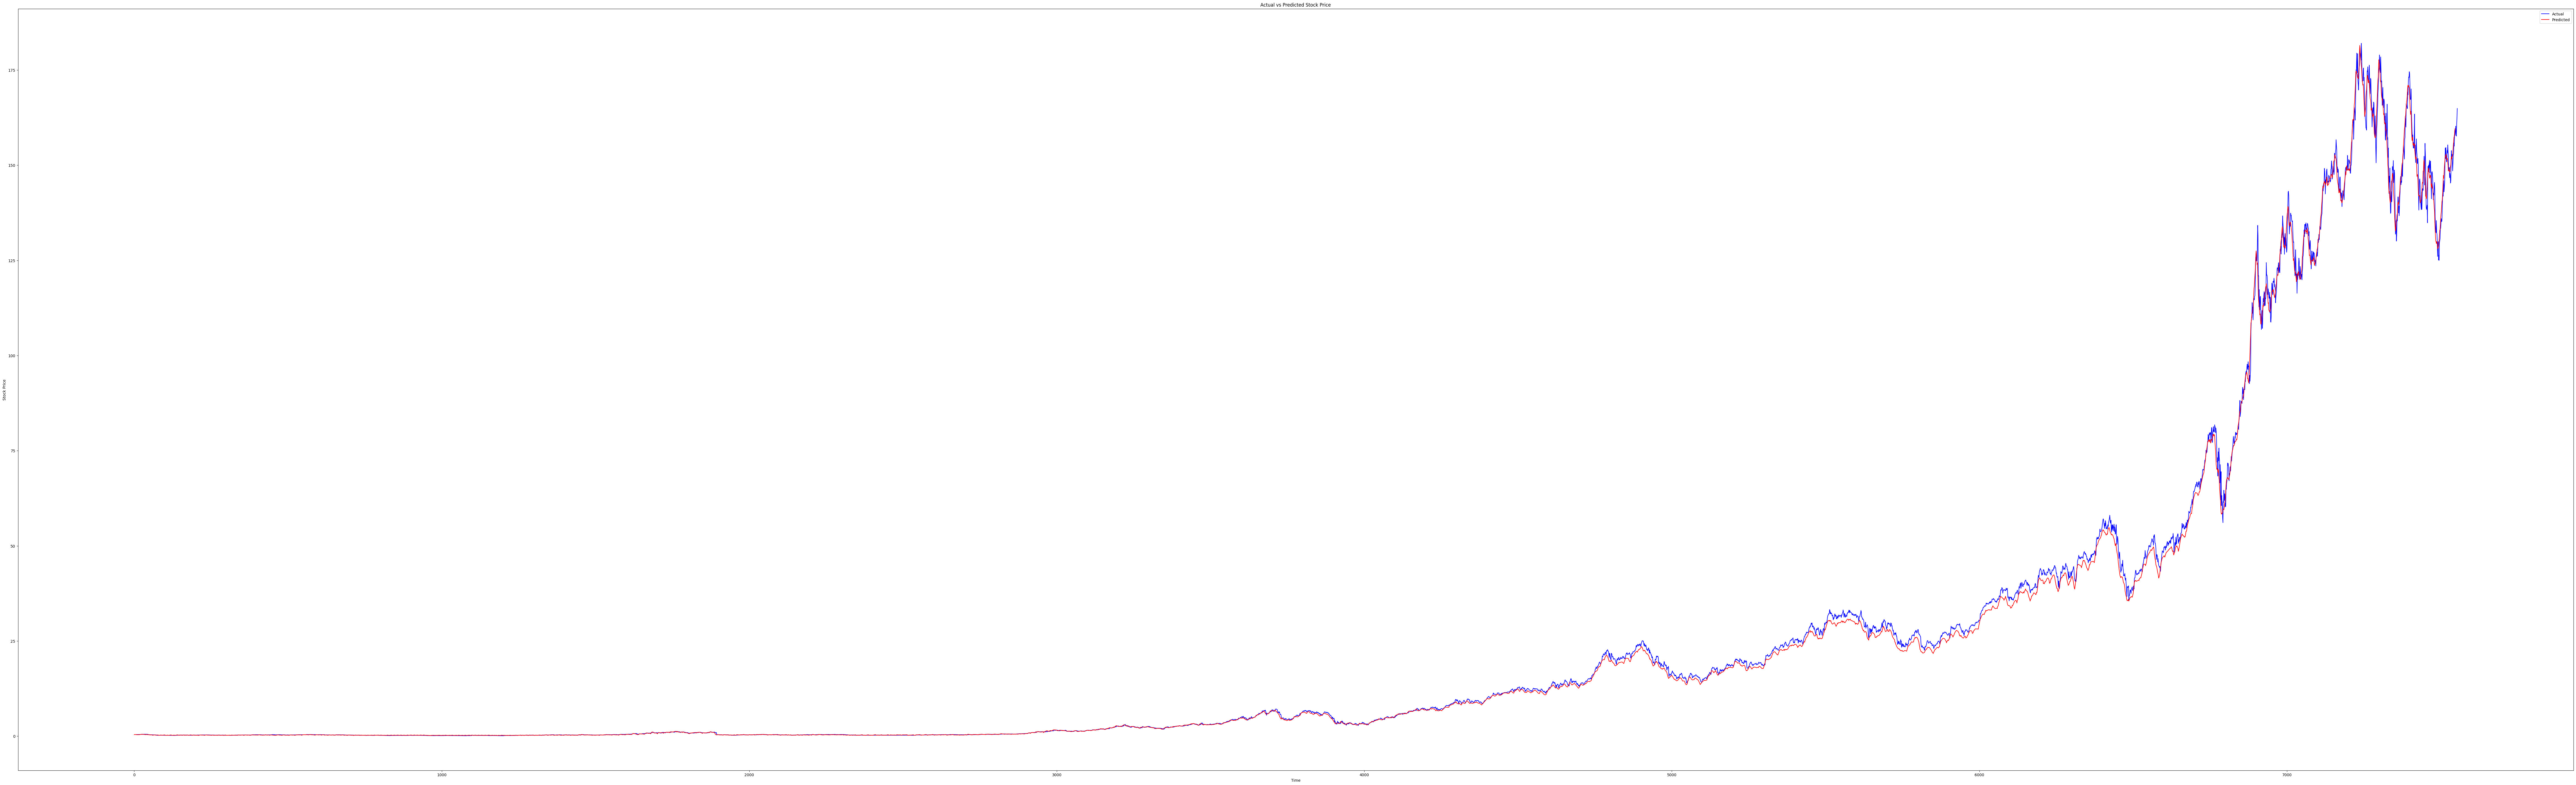

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(120,36))
plt.plot(actual_prices, color='blue', label='Actual')
plt.plot(predicted_prices, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.show()